# **Human Activity Recognition with Hidden Markov Models**

The goal of this project is to recognize human activities—walking, jumping, standing, and being still—using smartphone accelerometer and gyroscope data. Sensor signals were collected, cleaned, merged, and segmented into overlapping windows.

These features are modeled using a Hidden Markov Model (HMM), where hidden states represent the underlying activities. The Baum–Welch algorithm is used for training model parameters, and the Viterbi algorithm decodes the most likely activity sequence. This approach demonstrates how probabilistic models can capture temporal dynamics in motion data for reliable activity recognition.  

In [1]:
#Import necessary libraries
import os, glob, collections, pathlib, re
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt




In [2]:
# Mount Google Drive to access datasets
from google.colab import drive
drive.mount('/content/drive', force_remount=False)


Mounted at /content/drive


# **Data Collection and Visualization**

---



In [3]:
# HMM pipeline: find data, pick DATA_DIR, show examples, prep output)

import os, re, glob, pathlib, collections
import pandas as pd

# config
ROOT_GDRIVE = "/content/drive/MyDrive"
EXPECTED_FS_HZ = 50.0

# find sensor csvs
acc_files = glob.glob(f"{ROOT_GDRIVE}/**/Accelerometer*.csv", recursive=True)
gyr_files = glob.glob(f"{ROOT_GDRIVE}/**/Gyroscope*.csv",    recursive=True)

print(f"Found Accelerometer files: {len(acc_files)}")
print(f"Found Gyroscope files    : {len(gyr_files)}")

# detect activity folders
activity_dirs = set()
for p in acc_files + gyr_files:
    d = os.path.dirname(p)
    leaf = os.path.basename(d).lower()
    if leaf in {"jump","standing","still","walk","walking","jumping"}:
        activity_dirs.add(d)

if not activity_dirs:
    raise SystemExit("Couldn't find activity folders named jump/standing/still/walk with Accelerometer/Gyroscope CSVs.")

# choose dataset root
bases = [str(pathlib.Path(d).parent) for d in activity_dirs]
DATA_DIR = collections.Counter(bases).most_common(1)[0][0]

print("\nUsing DATA_DIR:", DATA_DIR)
subfolders = [d for d in os.listdir(DATA_DIR) if os.path.isdir(os.path.join(DATA_DIR, d))]
print("Activity subfolders under DATA_DIR:", subfolders)

# show a few file examples per activity
for act in sorted(subfolders):
    if act.lower() not in {"jump","standing","still","walk","walking","jumping"}:
        continue
    ex_acc = glob.glob(os.path.join(DATA_DIR, act, "Accelerometer*.csv"))[:3]
    ex_gyr = glob.glob(os.path.join(DATA_DIR, act, "Gyroscope*.csv"))[:3]
    print(f"\n[{act}] examples:")
    print("  Accelerometer:", [os.path.basename(p) for p in ex_acc])
    print("  Gyroscope   :", [os.path.basename(p) for p in ex_gyr])

# prepare output folder
merged_dir = os.path.join(DATA_DIR, "merged")
os.makedirs(merged_dir, exist_ok=True)
print("\nOutput folder for merged files will be:", merged_dir)

# clean one sensor df
def clean_df(df: pd.DataFrame, prefix: str) -> pd.DataFrame:
    df = df.rename(columns={c: c.strip().lower() for c in df.columns})
    aliases = {
        'seconds elapsed':'seconds_elapsed','elapsed':'seconds_elapsed','elapsed(s)':'seconds_elapsed',
        'time(s)':'seconds_elapsed','time (s)':'seconds_elapsed','timestamp':'seconds_elapsed','time':'seconds_elapsed'
    }
    for k, v in aliases.items():
        if k in df.columns and 'seconds_elapsed' not in df.columns:
            df.rename(columns={k: v}, inplace=True)
    if 'seconds_elapsed' not in df.columns:
        raise ValueError("No 'seconds_elapsed' (time) column found!")

    axes = [c for c in ['x','y','z'] if c in df.columns]
    df = df[['seconds_elapsed'] + axes].copy()
    df['seconds_elapsed'] = pd.to_numeric(df['seconds_elapsed'], errors='coerce')
    for ax in axes:
        df[ax] = pd.to_numeric(df[ax], errors='coerce')
    df = df.dropna(subset=['seconds_elapsed'])
    if df['seconds_elapsed'].duplicated().any():
        df = df.groupby('seconds_elapsed', as_index=False).mean(numeric_only=True)
    df = df.rename(columns={ax: f'{prefix}_{ax}' for ax in axes})
    return df.sort_values('seconds_elapsed').reset_index(drop=True)

# merge acc+gyro on nearest time with 50 Hz tolerance
def merge_acc_gyro(acc_path: str, gyro_path: str, fs: float = EXPECTED_FS_HZ) -> pd.DataFrame:
    acc  = clean_df(pd.read_csv(acc_path), 'acc')
    gyro = clean_df(pd.read_csv(gyro_path), 'gyro')
    tol = 0.5 / fs  # half-sample tolerance
    merged = pd.merge_asof(acc, gyro, on='seconds_elapsed', direction='nearest', tolerance=tol)
    for col in ['gyro_x','gyro_y','gyro_z']:
        if col not in merged.columns:
            raise ValueError(f"Missing column after merge: {col}")
    return merged.dropna(subset=['gyro_x','gyro_y','gyro_z']).reset_index(drop=True)


Found Accelerometer files: 50
Found Gyroscope files    : 50

Using DATA_DIR: /content/drive/MyDrive/hmm_activity/data
Activity subfolders under DATA_DIR: ['still', 'standing', 'jump', 'walk', 'merged']

[jump] examples:
  Accelerometer: ['Accelerometer(5).csv', 'Accelerometer(6).csv', 'Accelerometer(7).csv']
  Gyroscope   : ['Gyroscope(5).csv', 'Gyroscope(6).csv', 'Gyroscope(7).csv']

[standing] examples:
  Accelerometer: ['Accelerometer(10).csv', 'Accelerometer(11).csv', 'Accelerometer(12).csv']
  Gyroscope   : ['Gyroscope(10).csv', 'Gyroscope(11).csv', 'Gyroscope(12).csv']

[still] examples:
  Accelerometer: ['Accelerometer(5).csv', 'Accelerometer(6).csv', 'Accelerometer(7).csv']
  Gyroscope   : ['Gyroscope(5).csv', 'Gyroscope(6).csv', 'Gyroscope(7).csv']

[walk] examples:
  Accelerometer: ['Accelerometer(5).csv', 'Accelerometer(6).csv', 'Accelerometer(7).csv']
  Gyroscope   : ['Gyroscope(5).csv', 'Gyroscope(6).csv', 'Gyroscope(7).csv']

Output folder for merged files will be: /conte

In [6]:
# batch merge accelerometer+gyroscope at 50 Hz into DATA_DIR/merged

EXPECTED_FS_HZ = 50.0  # target fs

def natural_sort_key(p):
    b = os.path.basename(p)
    return [int(s) if s.isdigit() else s.lower() for s in re.split(r'(\d+)', b)]

def clean_df(df, prefix: str):
    # normalize headers and time column
    df = df.rename(columns={c: c.strip().lower() for c in df.columns})
    aliases = {
        'seconds elapsed':'timestamp','elapsed':'timestamp','elapsed(s)':'timestamp',
        'time(s)':'timestamp','time (s)':'timestamp','seconds_elapsed':'timestamp',
        'time':'timestamp'
    }
    for k, v in aliases.items():
        if k in df.columns and 'timestamp' not in df.columns:
            df.rename(columns={k: v}, inplace=True)
    if 'timestamp' not in df.columns:
        raise ValueError("No 'timestamp' (time) column found!")

    # keep time + available axes
    axes = [c for c in ['x','y','z'] if c in df.columns]
    df = df[['timestamp'] + axes].copy()

    # numeric cast and drop bad times
    df['timestamp'] = pd.to_numeric(df['timestamp'], errors='coerce')
    for ax in axes:
        df[ax] = pd.to_numeric(df[ax], errors='coerce')
    df = df.dropna(subset=['timestamp'])

    # average duplicate timestamps
    if df['timestamp'].duplicated().any():
        df = df.groupby('timestamp', as_index=False).mean(numeric_only=True)

    # prefix axes and sort
    df = df.rename(columns={ax: f'{prefix}_{ax}' for ax in axes})
    return df.sort_values('timestamp').reset_index(drop=True)

def merge_acc_gyro(acc_path, gyro_path, fs: float = EXPECTED_FS_HZ):
    # load, clean, and align by nearest timestamp
    acc  = clean_df(pd.read_csv(acc_path), 'acc')
    gyro = clean_df(pd.read_csv(gyro_path), 'gyro')
    tol = 0.5 / fs  # half-sample tolerance
    merged = pd.merge_asof(acc, gyro, on='timestamp', direction='nearest', tolerance=tol)

    # verify gyro present and drop unmatched
    for col in ['gyro_x','gyro_y','gyro_z']:
        if col not in merged.columns:
            raise ValueError(f"Missing column after merge: {col}")
    return merged.dropna(subset=['gyro_x','gyro_y','gyro_z']).reset_index(drop=True)

# output folder
if 'DATA_DIR' not in globals():
    raise RuntimeError("DATA_DIR is not defined. Run your discovery step first.")
OUT_DIR = os.path.join(DATA_DIR, "merged")
os.makedirs(OUT_DIR, exist_ok=True)

# merge all activity folders
activities = [d for d in os.listdir(DATA_DIR) if os.path.isdir(os.path.join(DATA_DIR, d)) and d.lower() != 'merged']
activities = sorted(activities, key=str.lower)

total_saved = 0
for act in activities:
    folder = os.path.join(DATA_DIR, act)

    # pick calibrated files
    acc_files  = [p for p in glob.glob(os.path.join(folder, "Accelerometer*.csv")) if "Uncalibrated" not in os.path.basename(p)]
    gyro_files = [p for p in glob.glob(os.path.join(folder, "Gyroscope*.csv"))    if "Uncalibrated" not in os.path.basename(p)]

    # pair by natural order
    acc_files.sort(key=natural_sort_key)
    gyro_files.sort(key=natural_sort_key)
    n = min(len(acc_files), len(gyro_files))
    if n == 0:
        print(f"No calibrated pairs in '{act}'."); continue

    print(f"\n{act}: pairing {n} file(s)")
    for i in range(n):
        acc_path, gyro_path = acc_files[i], gyro_files[i]
        try:
            merged = merge_acc_gyro(acc_path, gyro_path, fs=EXPECTED_FS_HZ)  # 50 Hz
            merged["activity"] = act.lower()  # label
            out_name = f"{act.lower()}_{i+1:02d}_merged.csv"
            merged.to_csv(os.path.join(OUT_DIR, out_name), index=False)
            print(f"  Saved {out_name} | rows={merged.shape[0]}")
            total_saved += 1
        except Exception as e:
            print(f"  Failed on {os.path.basename(acc_path)} + {os.path.basename(gyro_path)} → {e}")

print(f"\nDone. Wrote {total_saved} clean merged file(s) to: {OUT_DIR}")



jump: pairing 11 file(s)
  Saved jump_01_merged.csv | rows=964
  Saved jump_02_merged.csv | rows=766
  Saved jump_03_merged.csv | rows=828
  Saved jump_04_merged.csv | rows=894
  Saved jump_05_merged.csv | rows=948
  Saved jump_06_merged.csv | rows=696
  Saved jump_07_merged.csv | rows=713
  Saved jump_08_merged.csv | rows=740
  Saved jump_09_merged.csv | rows=760
  Saved jump_10_merged.csv | rows=802
  Saved jump_11_merged.csv | rows=770

standing: pairing 16 file(s)
  Saved standing_01_merged.csv | rows=704
  Saved standing_02_merged.csv | rows=789
  Saved standing_03_merged.csv | rows=864
  Saved standing_04_merged.csv | rows=868
  Saved standing_05_merged.csv | rows=866
  Saved standing_06_merged.csv | rows=853
  Saved standing_07_merged.csv | rows=930
  Saved standing_08_merged.csv | rows=893
  Saved standing_09_merged.csv | rows=874
  Saved standing_10_merged.csv | rows=998
  Saved standing_11_merged.csv | rows=941
  Saved standing_12_merged.csv | rows=906
  Saved standing_13_me

In [21]:
# Folder containing all merged files
merged_dir = Path(DATA_DIR) / "merged"
files = sorted(merged_dir.glob("*.csv"))

print("Total merged files found:", len(files))

# Combine all merged CSVs into one DataFrame
all_data = pd.concat([pd.read_csv(f) for f in files], ignore_index=True)

print("\nColumns:", all_data.columns.tolist())
print("Shape:", all_data.shape)
print(all_data.head(3))


Total merged files found: 50

Columns: ['timestamp', 'acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z', 'activity']
Shape: (41267, 8)
   timestamp     acc_x     acc_y     acc_z    gyro_x    gyro_y    gyro_z  \
0   0.119341  0.318755 -0.559750  0.184729  0.208629 -0.565315 -0.338257   
1   0.129311  0.422586 -0.373497  0.384686  0.233211 -0.661429 -0.369003   
2   0.139280  0.504881 -0.216885  0.659927  0.249413 -0.733556 -0.361532   

  activity  
0     jump  
1     jump  
2     jump  


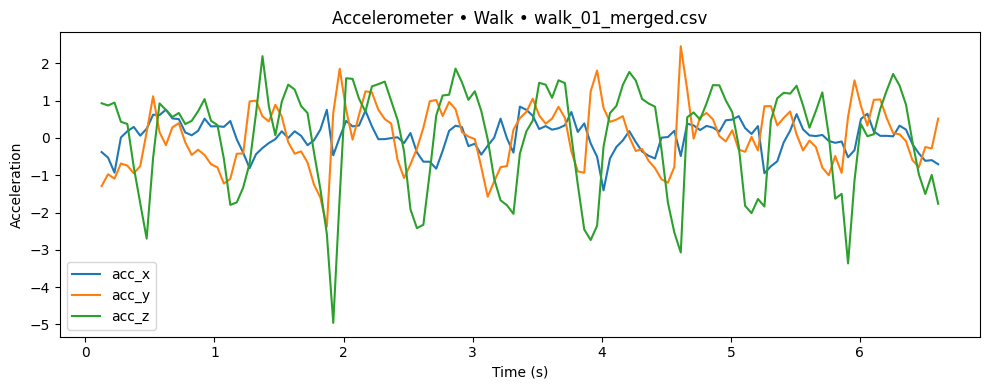

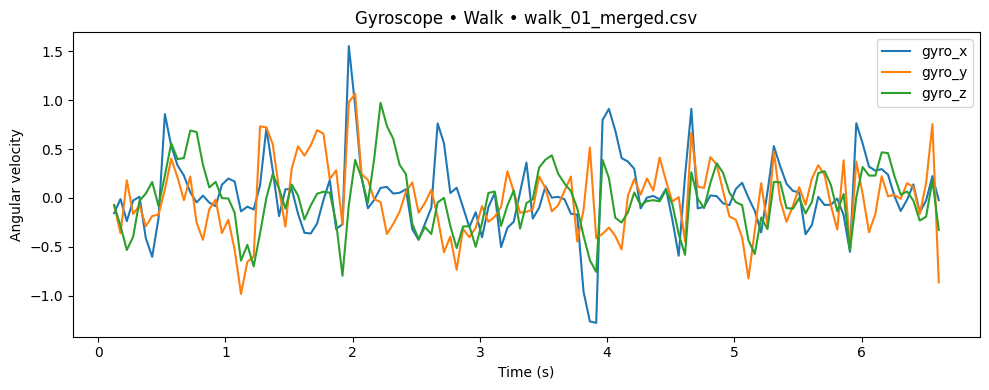

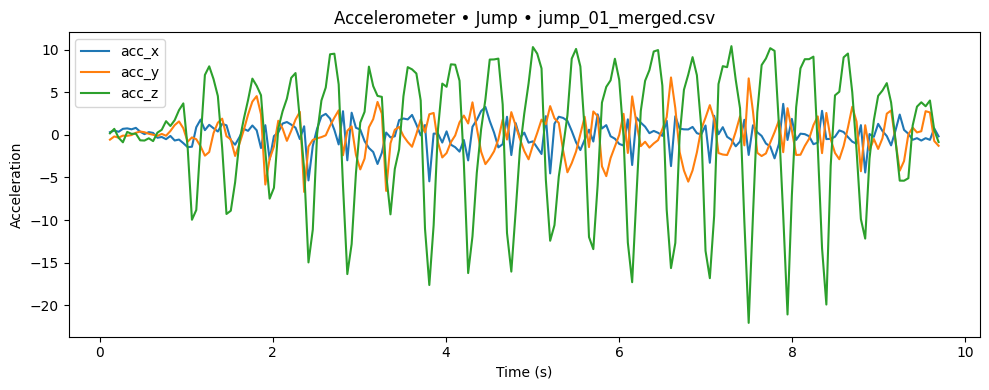

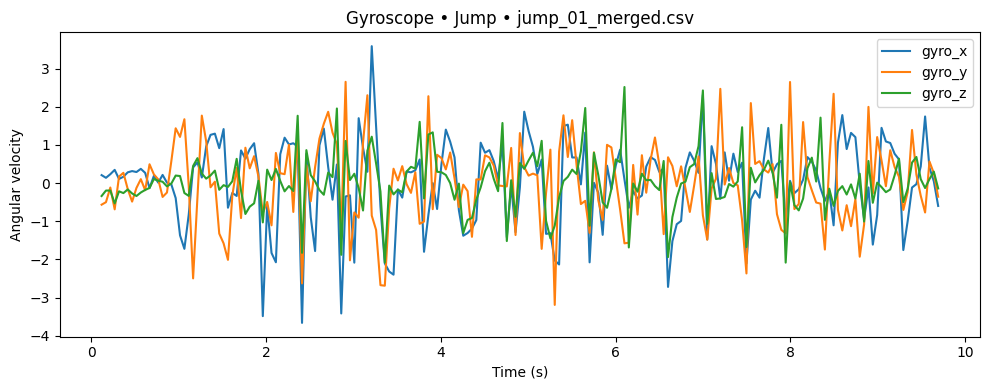

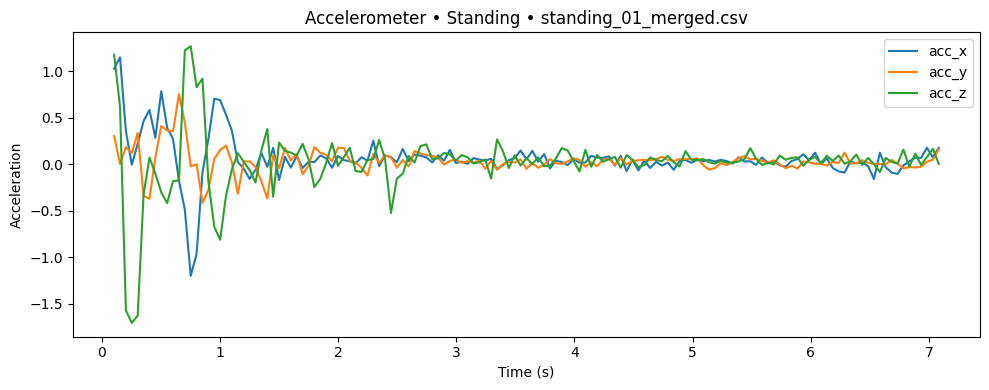

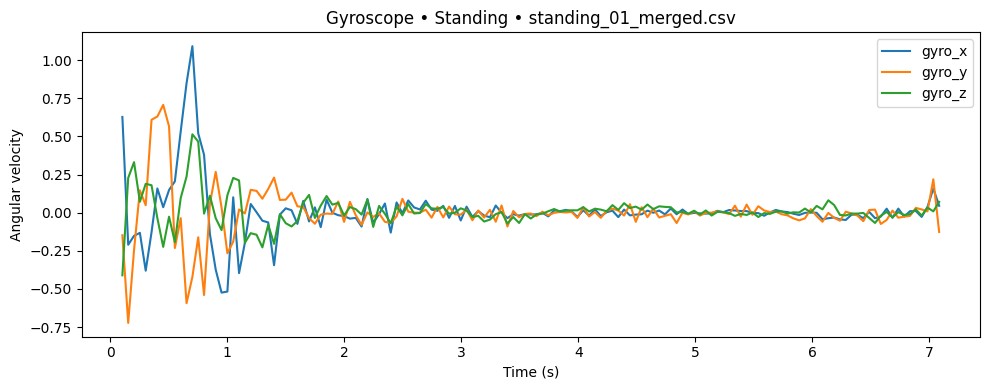

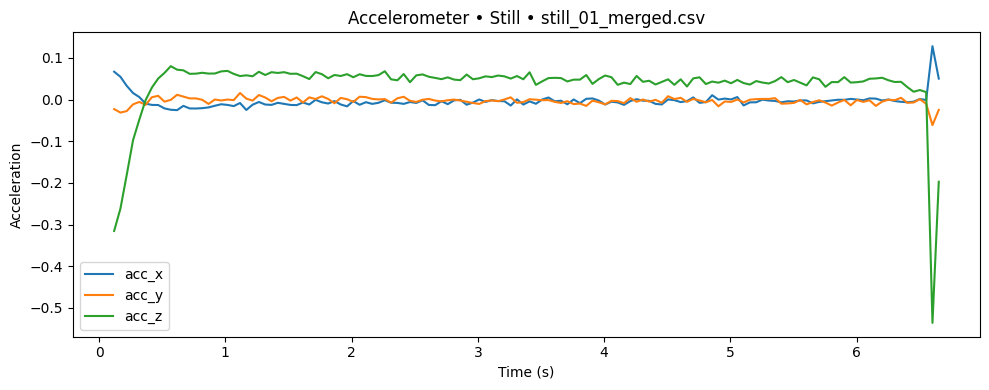

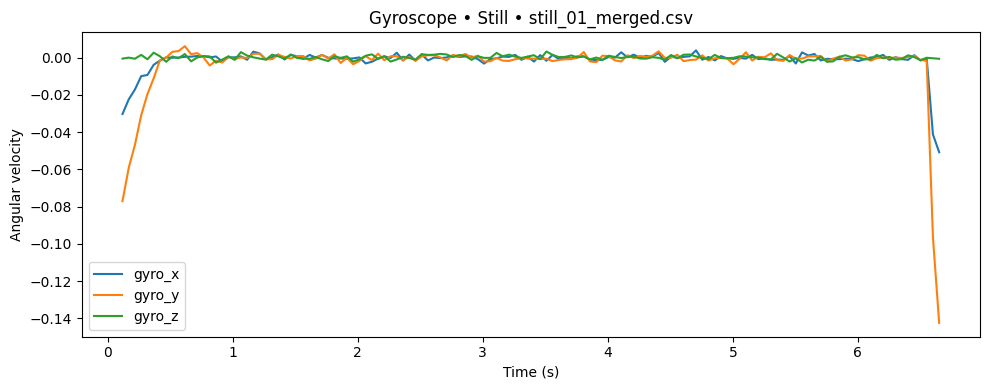

In [19]:
#Plot raw sensor data
activities = ["walk", "jump", "standing", "still"]

for act in activities:
    pattern = os.path.join(OUT_DIR, f"{act}_*_merged.csv")  # match your saved naming
    matches = sorted(glob.glob(pattern))
    if not matches:
        print(f"[WARN] No merged files found for activity: {act} (pattern: {pattern})")
        continue

    f = matches[0]  # first file for this activity
    df = pd.read_csv(f)

    # ensure numeric + sort by time
    for c in ["timestamp","acc_x","acc_y","acc_z","gyro_x","gyro_y","gyro_z"]:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")
    df = df.dropna(subset=["timestamp"]).sort_values("timestamp")

    # light decimation for plotting speed
    N = 5
    dplot = df.iloc[::N, :].copy()

    act_title = act.capitalize()
    base = os.path.basename(f)

    # Accelerometer plot
    plt.figure(figsize=(10, 4))
    if "acc_x" in dplot: plt.plot(dplot["timestamp"], dplot["acc_x"], label="acc_x")
    if "acc_y" in dplot: plt.plot(dplot["timestamp"], dplot["acc_y"], label="acc_y")
    if "acc_z" in dplot: plt.plot(dplot["timestamp"], dplot["acc_z"], label="acc_z")
    plt.xlabel("Time (s)")
    plt.ylabel("Acceleration")
    plt.title(f"Accelerometer • {act_title} • {base}")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Gyroscope plot
    plt.figure(figsize=(10, 4))
    if "gyro_x" in dplot: plt.plot(dplot["timestamp"], dplot["gyro_x"], label="gyro_x")
    if "gyro_y" in dplot: plt.plot(dplot["timestamp"], dplot["gyro_y"], label="gyro_y")
    if "gyro_z" in dplot: plt.plot(dplot["timestamp"], dplot["gyro_z"], label="gyro_z")
    plt.xlabel("Time (s)")
    plt.ylabel("Angular velocity")
    plt.title(f"Gyroscope • {act_title} • {base}")
    plt.legend()
    plt.tight_layout()
    plt.show()


**Insights from Sensor Data**




**Walking:** From the visuals we can see that the signals go up and down in a smooth, repeating rhythm, which what you’d expect from human walking footsteps.

**Jumping:** The lines shows big spikes which is expected of a jumping activity as it involves a sudden upward and downward motion.

**Standing:** From the visuals the signals start with small movements but quickly flatten out. Once stops moving, everything stays almost still. This matches the idea of a standing activity.

**Still:** The lines are almost completely flat for both sensors, showing no movement at all which indicates that the  sensors were stable and not picking up extra noise.



Each activity looks different enough to help the  HMM model recognize them